In [127]:
%load_ext autoreload
%autoreload 2

import sys         
sys.path.append('./../../src/') 
from data.ptbxl import create_features_dataset, get_feats_from_all_channels, load_ptbxl_data
from pathlib import Path
from signals.ecg import ECGSignal
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from signals.utils import parse_nested_feats
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed

TARGET = 'diagnostic_class'
DATASET_PATH = Path("./../../data/ptbxl")
SAMPLING_RATE = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
ptbxl_data = load_ptbxl_data(
    sampling_rate=SAMPLING_RATE,
    path = DATASET_PATH,
    target = TARGET
)

In [2]:
ptbxl_dataset = create_dataset()

train split:   0%|          | 0/12978 [00:00<?, ?it/s]

val split:   0%|          | 0/1642 [00:00<?, ?it/s]

test split:   0%|          | 0/1652 [00:00<?, ?it/s]

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

# model = SVC(probability=True)
model = LGBMClassifier()


X_train = ptbxl_dataset['train']['X']
y_train = ptbxl_dataset['train']['y']

X_val = ptbxl_dataset['val']['X']
y_val = ptbxl_dataset['val']['y']

X_test = ptbxl_dataset['test']['X']
y_test = ptbxl_dataset['test']['y']

model.fit(X_train, y_train)

LGBMClassifier()

In [175]:
save_as_torch_and_npy_files()

In [41]:
from evaluation.metrics import get_classification_metrics
from evaluation.visualisations import plot_feature_importance, plot_confusion_matrix

train_metrics = get_classification_metrics(model.predict_proba(X_train), y_train)
val_metrics = get_classification_metrics(model.predict_proba(X_val), y_val)
test_metrics = get_classification_metrics(model.predict_proba(X_test), y_test)

In [42]:
val_metrics, test_metrics

({'fscore': 0.6247407970724964,
  'acc': 0.7576323987538941,
  'auc': 0.919570282475384},
 {'fscore': 0.6511467628590049,
  'acc': 0.7808814400993171,
  'auc': 0.9213483635956324})

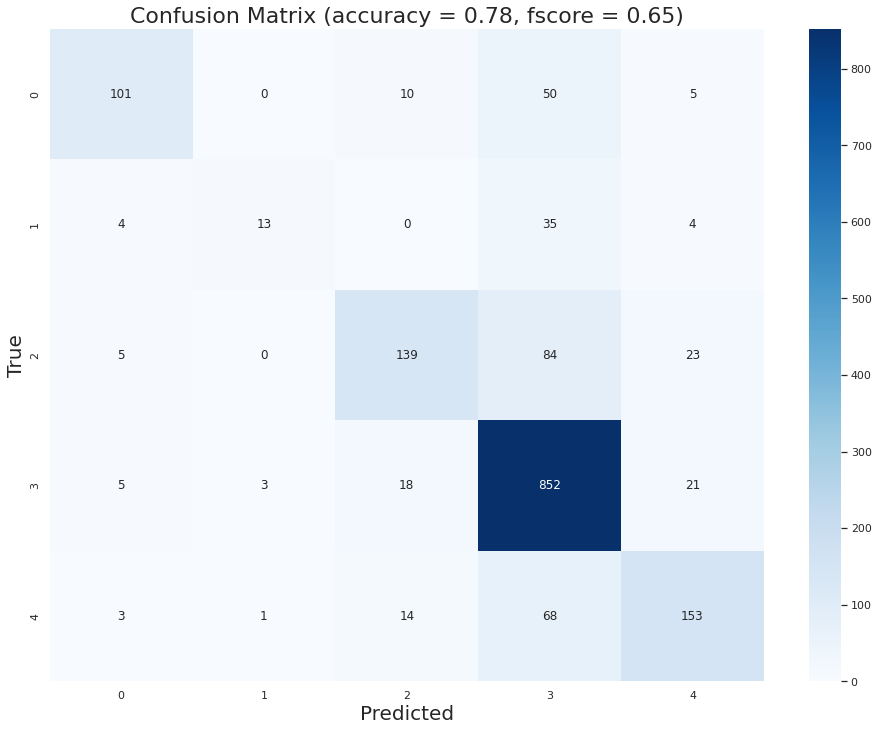

In [43]:
plot_confusion_matrix(y_test, model.predict(X_test), np.unique(y_train))

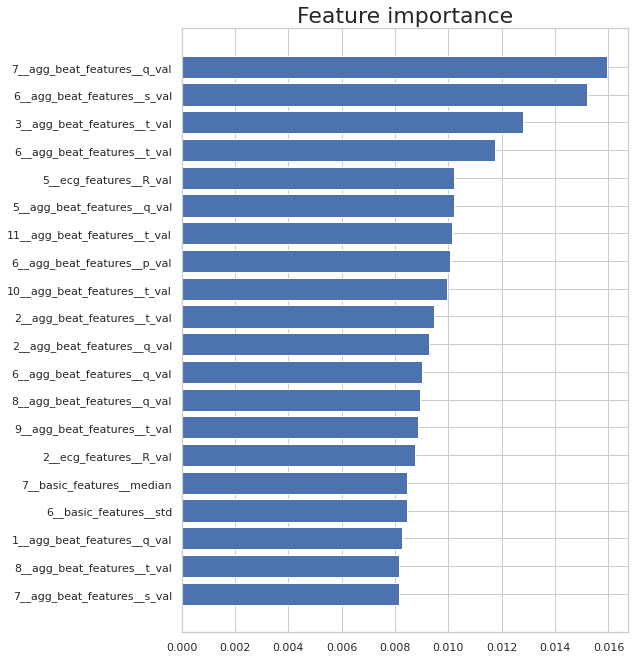

In [44]:
plot_feature_importance(X_train.columns.values, model.feature_importances_, n_best=20)

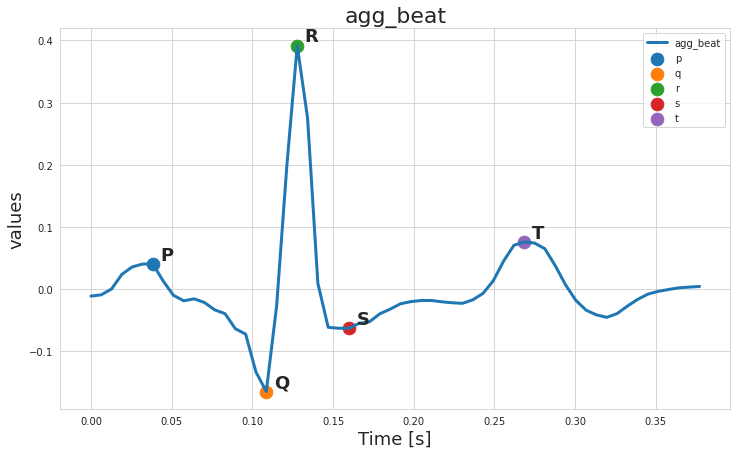

In [9]:
data = ptbxl_data['train']['X'][111, :, 0]
sig = ECGSignal("ecg", data, 100)
# sig.plot()
secg = sig.aggregate()
secg.plot_crit_points()

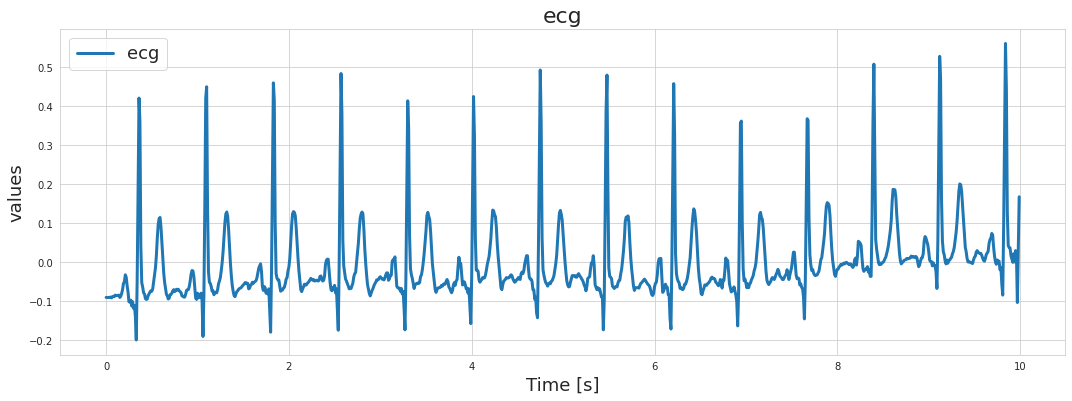

In [10]:
data = ptbxl_data['train']['X'][1111, :, 0]
sig.plot()

In [56]:
from torch import nn
import torch

class MLP(nn.Module):
    def __init__(self, in_size=1000, n_classes=5):
        super().__init__()
        self.model = nn.Sequential(
            # nn.Linear(in_size, in_size // 2),
            # nn.ReLU(),
            # nn.Linear(in_size // 2, in_size // 4),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(in_size, n_classes)
        )
        
    def forward(self, x):
        out = self.model(x)
        probs = F.softmax(out, dim=1)
        if torch.any(probs.isnan()) or torch.any(probs.isinf()):
            print(out)
        return probs
        

In [67]:
from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
from evaluation.metrics import get_classification_metrics


class PTBXLWaveFormClassifier(LightningModule):
    def __init__(self, in_dims, classifier: nn.Module, learning_rate: float = 1e-3):
        super().__init__()
        self.classifier = classifier
        self.learning_rate = learning_rate
        self.save_hyperparameters('in_dims', 'learning_rate')
    
    def forward(self, x):
        return self.classifier(x)

    def _common_step(self, batch, batch_ids, stage, log=True):
        x, labels = batch
        probs = self(x)
        log_probs = torch.log(probs)
        preds = log_probs.argmax(axis=1)
        if log:
            y_pred_proba = probs.detach().numpy()
            metrics = get_classification_metrics(y_pred_proba, labels, auc=stage in ('val', 'test'))
            for metric, val in metrics.items():
                self.log(f"{stage}/{metric}", val, on_step=False, on_epoch=True)
        return labels, probs, log_probs, preds
        
    def training_step(self, batch, batch_idx):
        labels, probs, log_probs, preds = self._common_step(batch, batch_idx, 'train', log=True)
        loss = F.nll_loss(log_probs, labels)
        return loss
    
    def validation_step(self, batch, batch_idx):
        labels, probs, log_probs, preds = self._common_step(batch, batch_idx, 'val', log=True)
        loss = F.nll_loss(log_probs, labels)
        return log_probs
    
    def predict_step(self, batch, batch_idx):
        _, _, _, preds = self._common_step(batch, batch_idx, 'predict', log=False)
        return preds

    def test_step(self, batch, batch_idx):
        _, _, _, preds = self._common_step(batch, batch_idx, 'test', log=True)
        return preds
    
    def test_epoch_end(self, test_step_outputs):
        pass
        # dummy_input = torch.zeros((1, self.hparams["in_dims"]), device=self.device)
        # model_filename = "model_final.onnx"
        # self.to_onnx(model_filename, dummy_input, export_params=True)
        # wandb.save(model_filename)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-3)

In [68]:
from data.ptbxl import PTBXLWaveformDataModule

ptbxl_datamodule = PTBXLWaveformDataModule(
    sampling_rate=100, target='diagnostic_class', batch_size=64, num_workers=8
)

mlp = MLP()
model = PTBXLWaveFormClassifier(1000, mlp, learning_rate=1e-3)
trainer = Trainer()
trainer.fit(model, ptbxl_datamodule)

/home/shate/.local/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/shate/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name       | Type | Params
------------------------------------
0 | classifier | MLP  | 5.0 K 
------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/shate/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [70]:
trainer.test(model, ptbxl_datamodule)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.5332929782082324     │
│         test/auc          │     0.508471124246488     │
│        test/fscore        │    0.19243253267031443    │
└───────────────────────────┴───────────────────────────┘

[{'test/fscore': 0.19243253267031443,
  'test/acc': 0.5332929782082324,
  'test/auc': 0.508471124246488}]

In [110]:
from data.ptbxl import TENSORS_DATA_PATH
import torch
from biosppy.signals.ecg import ecg

sampling_rate = 100
fs = sampling_rate
split = "train"

data = torch.load(TENSORS_DATA_PATH / f"records{sampling_rate}/{split}_data.pt")

In [4]:
def get_beats_from_signal(sig, fs=100):
    ecg_info = ecg(sig, fs, show=False)
    return ecg_info['templates']

def get_beats_from_all_channels(channels):
    return [get_beats_from_signal(sig) for sig in channels.T]


measurements_beats = Parallel(n_jobs=-1)(delayed(get_beats_from_all_channels)(channels) for channels in tqdm(data[:100]))

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
s = ECGSignal('', data[21, :, 0], fs)

/home/shate/Desktop/praca_magisterska/medical_signal_representation/notebooks/ecg/./../../src/signals/base.py:196: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1e918f0c10> has a label of '_child0' which cannot be automatically added to the legend.
  ax.legend(plots, labels, loc=0, fontsize=18)


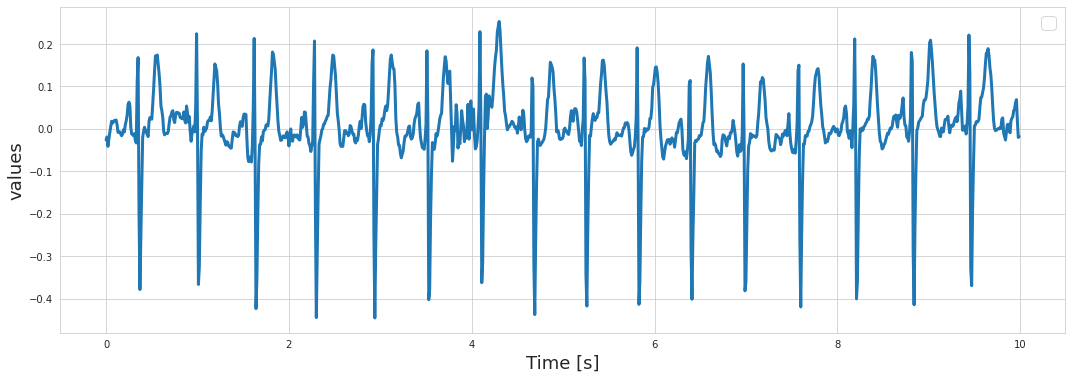

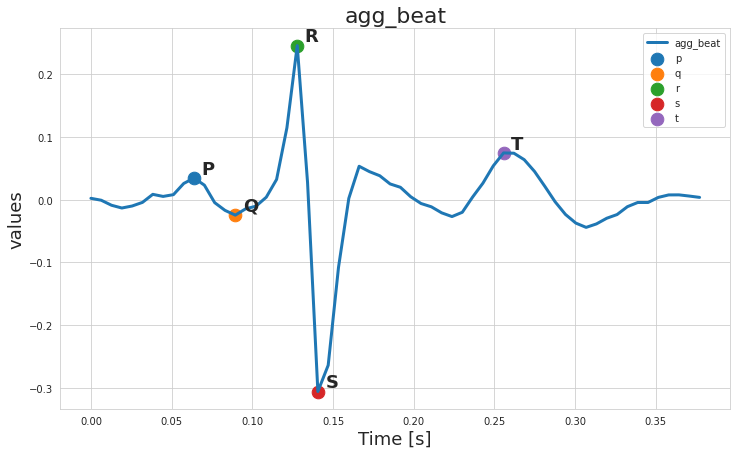

In [22]:
s.plot()
agg = s.aggregate()
agg.plot_crit_points()

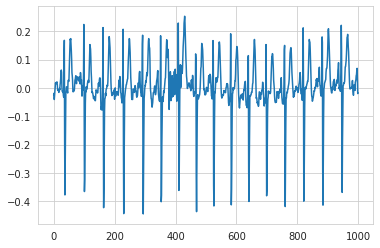

In [14]:
plt.plot(data[21, :, 0])

In [29]:
measurements_beats[4][0].shape

(11, 60)

In [8]:
[[len(beat) for beat in beats] for beats in measurements_beats]

[[10, 10, 10, 10, 10, 11, 11, 11, 11, 10, 10, 10],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
 [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
 [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
 [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
 [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
 [10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10],
 [13, 13, 13, 13, 13, 13, 15, 13, 13, 13, 13, 13],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [11, 11, 11, 12, 12, 11, 11, 11, 11, 11, 11, 11],
 [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
 [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
 [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
 [11, 11, 11, 11, 11, 11, 11

(60,)

In [126]:
def show_templates(sig, ax=None):
    ecg_info = ecg(sig, fs, show=False)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    t = ecg_info['templates_ts']
    templates = ecg_info['templates']
    for i, template in enumerate(templates):
        ax.plot(t, template, label=i)
    ax.plot(t, ecg_info['templates'].mean(axis=0), color='black', lw=1.5)
    ax.set_xlim([t[0], t[-1]])
    ax.set_title(f"{len(templates)} beats", fontsize=16)
    ax.legend()
    print(len(ecg_info['templates']))

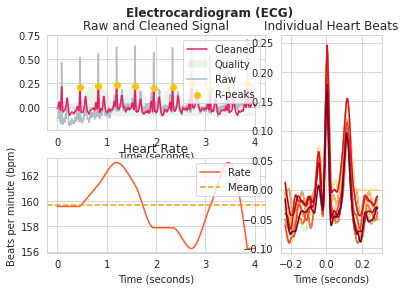

In [99]:
import neurokit2 as nk

# Generate 15 seconds of ECG signal (recorded at 250 samples / second)
ecg = data[0, :, 0]#nk.ecg_simulate(duration=10, sampling_rate=100, heart_rate=70)

# Process it
signals, info = nk.ecg_process(ecg, sampling_rate=250)

# Visualise the processing
nk.ecg_plot(signals, sampling_rate=250, show_type='default')

In [100]:
signals

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,-0.119,-0.017468,159.574468,0.313933,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,-0.116,-0.014989,159.574468,0.313933,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,-0.120,-0.013391,159.574468,0.313933,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,-0.117,-0.010875,159.574468,0.313933,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,-0.103,-0.005640,159.574468,0.313933,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.106,0.070394,156.250000,0.016512,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
996,0.090,0.056200,156.250000,0.016512,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
997,0.069,0.041605,156.250000,0.016512,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
998,0.086,0.024281,156.250000,0.016512,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


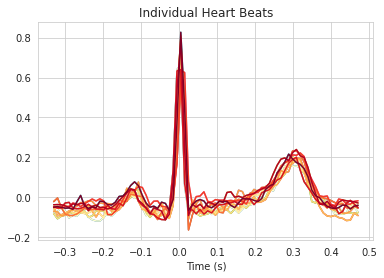

In [124]:
sig = data[2, :, 0]
qrs_epochs = nk.ecg_segment(sig.numpy(), rpeaks=None, sampling_rate=100, show=True)

In [125]:
qrs_epochs['2']

,Signal,Index,Label
-0.329079,-0.082,169,2
-0.318963,-0.108,170,2
-0.308846,-0.095,171,2
-0.298730,-0.090,172,2
-0.288614,-0.082,173,2
...,...,...,...
0.429647,-0.083,244,2
0.439764,-0.080,245,2
0.449880,-0.079,246,2
0.459996,-0.082,247,2


In [107]:
r_mask = (signals.ECG_R_Peaks == 1).values
p_onset_mask = (signals.ECG_P_Onsets == 1).values
t_offset_mask = (signals.ECG_T_Offsets == 1).values

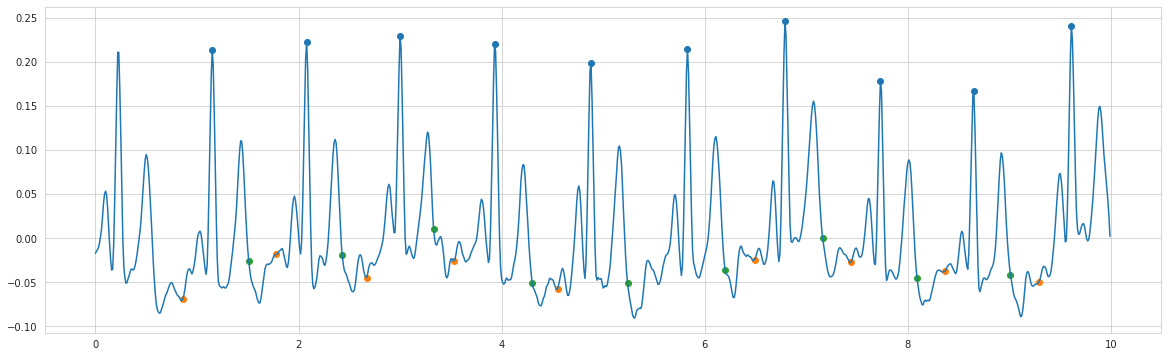

In [108]:
fig, ax = plt.subplots(figsize=(20, 6))
t, data = signals.index.values / 100, signals.ECG_Clean
ax.plot(t, data)
ax.scatter(t[r_mask], data[r_mask])
ax.scatter(t[p_onset_mask], data[p_onset_mask])
ax.scatter(t[t_offset_mask], data[t_offset_mask])

In [133]:
qrs_epochs['1']

,Signal,Index,Label
-0.329079,-0.074,72,1
-0.318963,-0.074,73,1
-0.308846,-0.046,74,1
-0.298730,-0.070,75,1
-0.288614,-0.104,76,1
...,...,...,...
0.429647,-0.085,147,1
0.439764,-0.077,148,1
0.449880,-0.047,149,1
0.459996,-0.050,150,1


In [147]:
(template.index.values[-1] - template.index.values[0]) * len(qrs_epochs.items())

11.798746790227595

In [148]:
(ecg_info['templates_ts'][-1] - ecg_info['templates_ts'][0]) * len(ecg_info['templates'])

11.21

In [257]:
ecg_sig = ECGSignal('', sig, 100)

In [268]:
ecg_sig.aggregate()

TypeError: object of type 'NoneType' has no len()

In [330]:
[beat.resample_with_interpolation(1000, kind='pchip').n_samples for beat in ecg_sig.get_beats()]

[1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000]

In [326]:
[beat.interpolate(beat.fs*5, 'pchip').n_samples for beat in ecg_sig.get_beats()]

[246,
 241,
 246,
 246,
 251,
 251,
 256,
 256,
 256,
 251,
 256,
 251,
 251,
 246,
 246,
 246,
 241,
 241,
 246]

52 1000 260


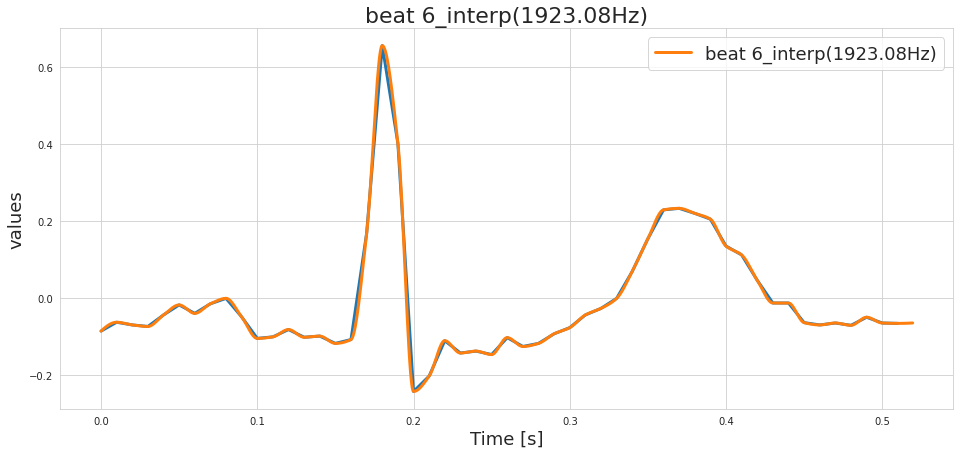

In [331]:
beat = ecg_sig.get_beats()[6]

fig, ax = plt.subplots(figsize=(16, 7))
beat.plot(ax=ax)
interp_resampled = beat.resample_with_interpolation(1000, kind='pchip')
# beat.resample(1000).plot(ax=ax)
interp = beat.interpolate(beat.fs*5, kind='pchip')

# interp.plot(ax=ax)
interp_resampled.plot(ax=ax)
print(beat.n_samples, interp_resampled.n_samples, interp.n_samples)

In [332]:
beat.time[-1], 

0.51

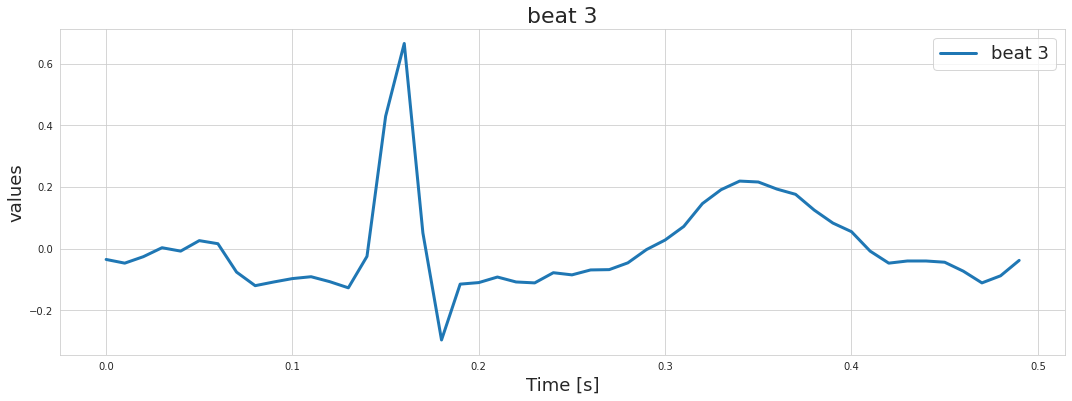

In [274]:
beat.plot()

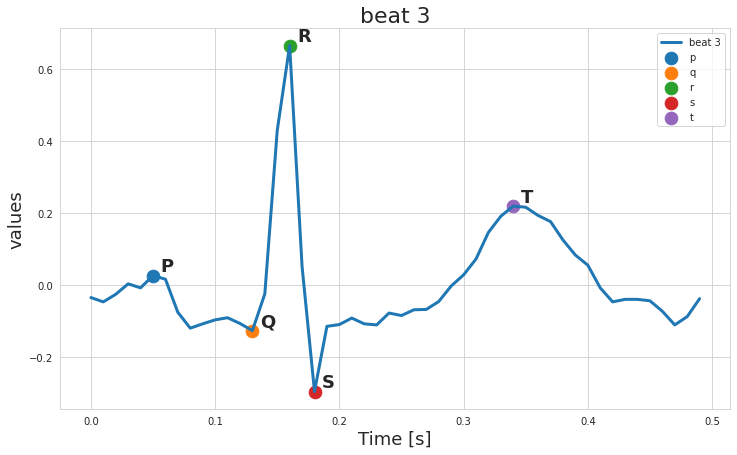

In [267]:
ecg_sig.get_beats()[3].plot_crit_points()

In [253]:
nk.ecg_peaks(sig, 100)[1]['ECG_R_Peaks']

array([ 68, 116, 165, 214, 264, 314, 365, 416, 467, 517, 568, 618, 668,
       717, 766, 815, 863, 911, 960])

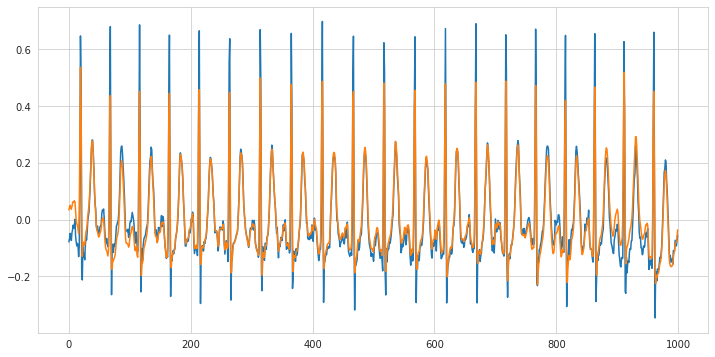

In [229]:
plt.figure(figsize=(12, 6))
plt.plot(sig)
clean_ecg = nk.ecg_clean(sig, sampling_rate=fs)
plt.plot(clean_ecg)


Text(0.5, 1.0, '19')

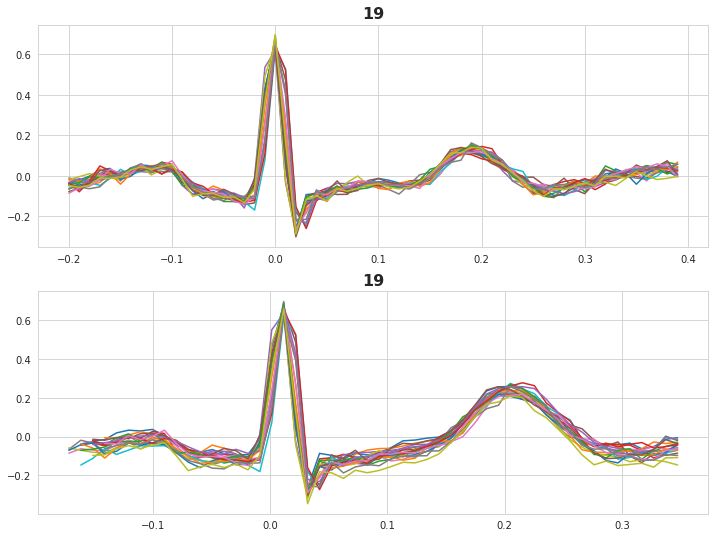

In [246]:
sig = data[67, :, 0]
ecg_info = ecg(sig, 100, show=False)
intervals, beats_times, beats_data = get_ecg_beats(sig, 100)

fig, axes = plt.subplots(2, 1, figsize=(12, 9))

for template in ecg_info['templates']:
    axes[0].plot(ecg_info['templates_ts'], template)

for t, d in zip(beats_times, beats_data):
    axes[1].plot(t, d)
    
axes[0].set_title(len(ecg_info['templates']), fontsize=16, fontweight='bold')
axes[1].set_title(len(qrs_epochs.items()), fontsize=16, fontweight='bold')

In [245]:
def get_ecg_beats(ecg_sig, fs=100, return_raw=True):
    clean_ecg = nk.ecg_clean(ecg_sig, sampling_rate=fs)
    qrs_epochs = nk.ecg_segment(clean_ecg, rpeaks=None, sampling_rate=fs, show=False)
    beats_times = []
    beats_data = []
    intervals = []
    prev_end_idx = qrs_epochs['1'].Index.values[-1]
    for idx, beat in qrs_epochs.items():
        idx = int(idx)
        if idx == 1:
            beats_times.append(beat.index.values)
            beats_data.append(beat.Signal.values)
        else:
            start_idx = np.where(beat.Index.values == prev_end_idx)[0][0]
            beat = beat.iloc[start_idx:]
            beats_times.append(beat.index.values)
            beats_data.append(beat.Signal.values)
        prev_end_idx = beat.Index.values[-1]
        intervals.append([beat.Index.values[0], beat.Index.values[-1]])

    avg_start_time = np.median([beat[0] for beat in beats_times[1:]])
    first_beat_mask = beats_times[0] > avg_start_time
    beats_times[0] = beats_times[0][first_beat_mask]
    beats_data[0] = beats_data[0][first_beat_mask]
    intervals[0][0] = intervals[0][0] + (first_beat_mask == False).sum()
    intervals = [tuple(interval) for interval in intervals]
    if return_raw:
        beats_data = [ecg_sig[start_idx:end_idx+1] for start_idx, end_idx in intervals]
    return intervals, beats_times, beats_data

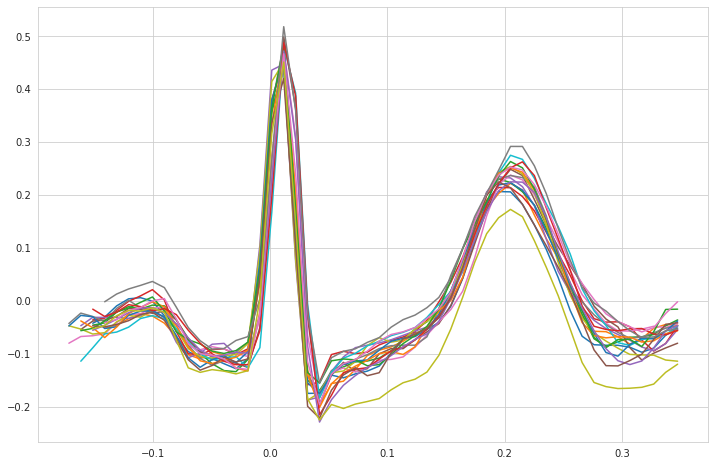

In [212]:
fig, ax = plt.subplots(figsize=(12, 8))

for t, d in zip(beats_times, beats_data):
    ax.plot(t, d)

In [171]:
first = qrs_epochs['1']
second = qrs_epochs['2']

In [173]:
first.Index.values[-1]

101

19


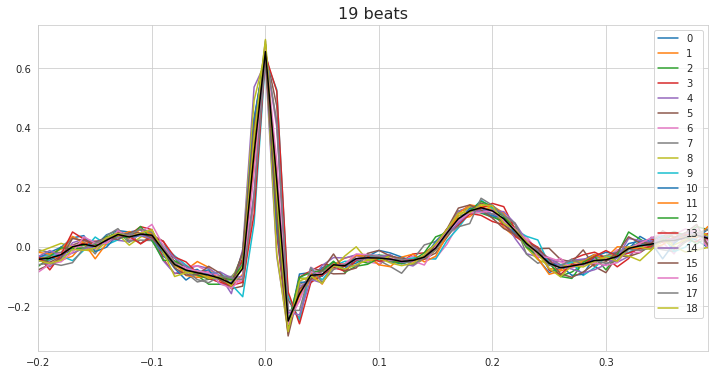

In [69]:
sig = data[67, :, 0]
show_templates(sig)

12


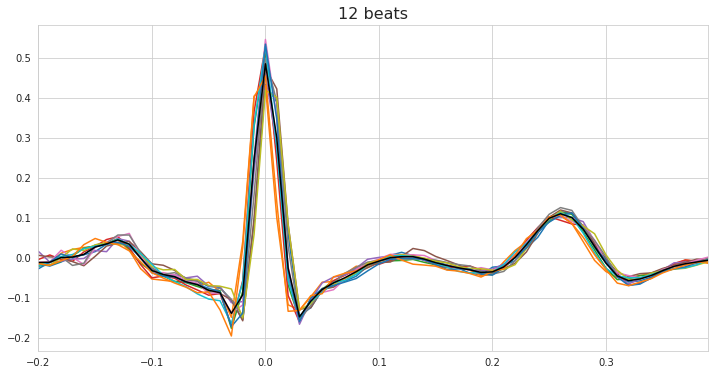

In [55]:
sig = data[22, :, 0]
show_templates(sig)

In [ ]:
class PTBXLPerBeatWaveformDataset(Dataset):
    """PTB-XL Dataset class used in DeepLearning models."""

    def __init__(self, split, sampling_rate=100, target="diagnostic_class", transform=None):
        # TODO: target is still not used -> only diagnostic_class labels are saved as tensors
        # TODO: sampling_rate works only for 100 -> 100 fs samples are saves as tensors

        self.data = torch.load(TENSORS_DATA_PATH / f"records{sampling_rate}/{split}_data.pt")
        self.labels = np.load(TENSORS_DATA_PATH / f"records{sampling_rate}/{split}_labels.npy", allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.data[idx][:, 0].float(), self.labels[idx]


class PTBXLPerBeatWaveformDataModule(LightningDataModule):
    """PTB-XL DataModule class used as DeepLearning models DataLoaders provider."""

    def __init__(self, sampling_rate=100, target="diagnostic_class", batch_size: int = 64, num_workers=8):
        super().__init__()
        self.sampling_rate = sampling_rate
        self.target = target
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train = None
        self.val = None
        self.test = None

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train = PTBXLWaveformDataset(split="train", sampling_rate=self.sampling_rate, target=self.target)
            self.val = PTBXLWaveformDataset(split="val", sampling_rate=self.sampling_rate, target=self.target)
        if stage == "test" or stage is None:
            self.test = PTBXLWaveformDataset(split="test", sampling_rate=self.sampling_rate, target=self.target)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=10 * self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=10 * self.batch_size, num_workers=self.num_workers)
